In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
from torch import logsumexp
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 64
STEPS = 10
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS = D + K
BATCH_SIZE = 10
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-4
CUDA = False

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
# mus_true = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
# covs = torch.from_numpy(np.load('gmm_dataset2/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
num_seqs = Zs.shape[0]

In [4]:
def StatsGMM(Xs, Zs, K, D):
    """
    Xs is B * N * D
    Zs is B * N * K
    stat1 corresponds I[z_n=1], ..., I[z_n=K]
    stat2 corresponds I[z_n=1]x_n, ..., I[z_n=K]x_n
    stat3 corresponds I[z_n=1]x_n**2, ..., I[z_n=K]x_n**2
    return B * (K+D*K+D*K)
    """
    stat1 = Zs.sum(1)
    stat2 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), Xs.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    stat3 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), torch.mul(Xs, Xs).unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    return stat1, stat2, stat3, torch.cat((stat1, stat2.view(-1, D*K), stat3.view(-1, D*K)), dim=-1)

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_stats))
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
        self.enc_hidden2 = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.mus_mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.mus_log_std = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        hidden = self.enc_hidden(stats)
        alpha = torch.exp(self.sigmas_log_alpha(hidden)).view(-1, K, D) ## B * K * D
        beta = torch.exp(self.sigmas_log_beta(hidden)).view(-1, K, D) ## B * K * D
        precisions = Gamma(alpha, beta).sample((num_samples,)) ## S * B * K * D
        
        hidden2 = self.enc_hidden2(stats)                 
        mus_mean = self.mus_mean(hidden2).view(-1, K, D)
        mus_sigma = torch.exp(self.mus_log_std(hidden2).view(-1, K, D))
        mus = Normal(mus_mean, mus_sigma).sample((num_samples,))  
        return alpha, beta, precisions, mus_mean, mus_sigma, mus

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc, optimizer
enc, optimizer = initialize()

In [7]:
prior_mean = torch.zeros((BATCH_SIZE, K, D))
prior_sigma = torch.ones((BATCH_SIZE, K, D))
prior_alpha = torch.ones((BATCH_SIZE, K, D)) * 2.0
prior_beta = torch.ones((BATCH_SIZE, K, D)) * 2.0

def log_joints_gmm(X, Z, Pi, mus, precisions, N, D, K, prior_mean, prior_sigma, prior_alpha, prior_beta, batch_size):
    log_probs = torch.zeros(batch_size).float()
    ## priors on mus and sigmas, S * B
    log_probs = log_probs + Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1)
    log_probs = log_probs + Gamma(prior_alpha, prior_beta).log_prob(precisions).sum(-1).sum(-1)
    ## Z B-by-T-by-K
    log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1)
    labels = Z.nonzero()
    sigmas = 1. / torch.sqrt(precisions)
    log_probs = log_probs + Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), 
                                   sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(X).sum(-1).sum(-1)
    return log_probs

def inti_global(K, D, prior_mean, prior_sigma, prior_alpha, prior_beta, batch_size):
    mus = Normal(prior_mean, prior_sigma).sample()
    precisions = Gamma(prior_alpha, prior_beta).sample()
    ## log prior size B
    log_p =  Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1) + Gamma(prior_alpha, prior_beta).log_prob(precisions).sum(-1).sum(-1)
    return mus, precisions, log_p

def E_step(X, mus, precisions, N, D, K):
    mus_expand = mus.unsqueeze(0).repeat(N, 1, 1, 1).transpose(0, 2)
    sigmas = 1. / torch.sqrt(precisions)
    sigmas_expand = sigmas.unsqueeze(0).repeat(N, 1, 1, 1).transpose(0, 2) ## K * B * N * D
    log_gammas = Normal(mus_expand, sigmas_expand).log_prob(X).sum(-1).permute(1, 2, 0) ## B * N * K
    gammas = torch.exp(log_gammas - logsumexp(log_gammas, -1).unsqueeze(-1))
    Z = cat(gammas).sample() ## B * N * K
    log_q_z = cat(gammas).log_prob(Z).sum(-1) ## B
    return Z, log_q_z

def rws(Xs, Pi, N, K, D, num_samples, steps, batch_size):
    """
    rws gradient estimator
    sis sampling scheme
    no resampling
    """
    log_increment_weights = torch.zeros((steps, num_samples, batch_size))
    log_uptonow_weights = torch.zeros((steps, num_samples, batch_size))
    Z_samples = torch.zeros((num_samples, batch_size, N, K))
    for m in range(steps):
        if m == 0:
            for l in range(num_samples):
                mus, precisions, log_p = inti_global(K, D, prior_mean, prior_sigma, prior_alpha, prior_beta, batch_size)
                Z, log_q_z = E_step(Xs, mus, precisions, N, D, K)
                Z_samples[l] = Z
                labels = Z.nonzero()
                log_likelihood_z = cat(Pi).log_prob(Z).sum(-1)
                sigmas = 1. / torch.sqrt(precisions)
                log_likelihood_x = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(Xs).sum(-1).sum(-1)
                log_increment_weights[m, l] = log_likelihood_x + log_likelihood_z - log_q_z     
                log_uptonow_weights[m, l] = log_likelihood_x + log_likelihood_z - log_q_z       
        else:
            for l in range(num_samples):
                Z = Z_samples[l]
                data = torch.cat((Xs, Z), dim=-1).view(batch_size*N, -1)
                alpha, beta, precisions, mus_mean, mus_sigma, mus = enc(data, K, D, 1, batch_size)            
                log_q_eta =  Normal(mus_mean, mus_sigma).log_prob(mus[0]).sum(-1).sum(-1) + Gamma(alpha, beta).log_prob(precisions[0]).sum(-1).sum(-1)## B
                Z, log_q_z = E_step(Xs, mus[0], precisions[0], N, D, K)
                Z_samples[l] = Z
                log_p = log_joints_gmm(Xs, Z, Pi, mus[0], precisions[0], N, D, K, prior_mean, prior_sigma, prior_alpha, prior_beta, batch_size)
                log_increment_weights[m, l] = log_p - log_q_z - log_q_eta
                log_uptonow_weights[m ,l] = log_increment_weights[m, l] + log_uptonow_weights[m-1 ,l]
    log_final_weights = log_uptonow_weights[-1]
    log_local_weights = log_increment_weights[-1]
    
    
#     local_weights = torch.exp(log_local_weights - logsumexp(log_local_weights, 0)).detach()
    weights = torch.exp(log_final_weights - logsumexp(log_final_weights, 0)).detach()
#     overall_weights = torch.exp(log_uptonow_weights - logsumexp(log_uptonow_weights, 1).unsqueeze(1).repeat(1, num_samples, 1)).detach()
    
    eubo = torch.mul(weights, log_final_weights).sum(0).mean()
    elbo = log_final_weights.mean(0).mean()
    
    ess = (1./ (weights ** 2).sum(0)).mean()
    
#     eubolocal = torch.mul(local_weights, log_local_weights).sum(0).mean()
#     elbolocal = log_local_weights.mean(0).mean()
    
#     euboave = torch.mul(overall_weights, log_increment_weights).sum(1).mean(0).mean()
#     elboave = log_increment_weights.mean(1).mean(0).mean()
    
    return eubo, elbo, ess 

def shuffler(batch_Xs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    return torch.gather(batch_Xs, 1, indices_Xs)

In [8]:
EUBOs = []
ELBOs = []
ESSs = []
num_batches = int((Xs.shape[0] / BATCH_SIZE))

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(num_seqs)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Xs = shuffler(batch_Xs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess = rws(batch_Xs, Pi, N, K, D, NUM_SAMPLES, STEPS, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)

    time_end = time.time()
    print('epoch=%d, EUBO=%f, ELBO=%f, ESS=%.3f (%ds)' % (epoch, EUBO, ELBO, ESS, time_end - time_start))

epoch=0, EUBO=-80625.296670, ELBO=-158901.486401, ESS=1.003 (45s)
epoch=1, EUBO=-6801.265312, ELBO=-8195.867935, ESS=1.009 (44s)
epoch=2, EUBO=-4439.711646, ELBO=-4897.084761, ESS=1.016 (43s)
epoch=3, EUBO=-3748.667180, ELBO=-4095.511106, ESS=1.018 (44s)
epoch=4, EUBO=-2905.300969, ELBO=-3138.401809, ESS=1.020 (44s)
epoch=5, EUBO=-2773.516589, ELBO=-2977.678586, ESS=1.021 (44s)
epoch=6, EUBO=-2671.569431, ELBO=-2867.832876, ESS=1.025 (44s)
epoch=7, EUBO=-2644.484387, ELBO=-2838.937239, ESS=1.034 (44s)
epoch=8, EUBO=-2699.311067, ELBO=-2887.474951, ESS=1.022 (48s)
epoch=9, EUBO=-2747.149910, ELBO=-2941.774028, ESS=1.034 (48s)
epoch=10, EUBO=-2640.315818, ELBO=-2831.475510, ESS=1.030 (46s)
epoch=11, EUBO=-2526.022732, ELBO=-2707.125642, ESS=1.025 (48s)
epoch=12, EUBO=-2538.719624, ELBO=-2714.659910, ESS=1.032 (47s)
epoch=13, EUBO=-2506.906042, ELBO=-2678.514856, ESS=1.033 (45s)
epoch=14, EUBO=-2462.770735, ELBO=-2629.161626, ESS=1.045 (44s)
epoch=15, EUBO=-2426.177380, ELBO=-2594.396667,

KeyboardInterrupt: 

In [9]:
def save_results(EUBOs, ELBOs, ESSs, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE):
    fout = open('amorgibbs-steps=%d-samples=%d-lr=%d.txt' % (STEPS, NUM_SAMPLES, LEARNING_RATE), 'w+')
    fout.write('EUBOs, ELBOs, ESSs\n')
    for i in range(len(EUBOs)):
        fout.write(str(EUBOs[i]) + ', ' + str(ELBOs[i]) + ', ' + str(ESSs[i]) + '\n')
    fout.close()
torch.save(enc.state_dict(), 'models/amorgibbs-steps=%d-samples=%d-lr=%d' % (STEPS, NUM_SAMPLES, LEARNING_RATE))
save_results(EUBOs, ELBOs, ESSs, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [14]:
def plot_results(EUBOs, ELBOs, ESSs, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(30, 30))
    fig.tight_layout()
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.plot(np.array(EUBOs) / STEPS, 'r', label='EUBOs')
    ax1.plot(np.array(ELBOs) / STEPS, 'b', label='ELBOs')
    ax1.tick_params(labelsize=18)
    ax2.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-250, -180])
    ax1.legend()
    ax2.legend()
    ax2.tick_params(labelsize=18)
    plt.savefig('amorgibbs_results_learn_both_lr=%.1E_samples=%d.svg' % (lr, num_samples))

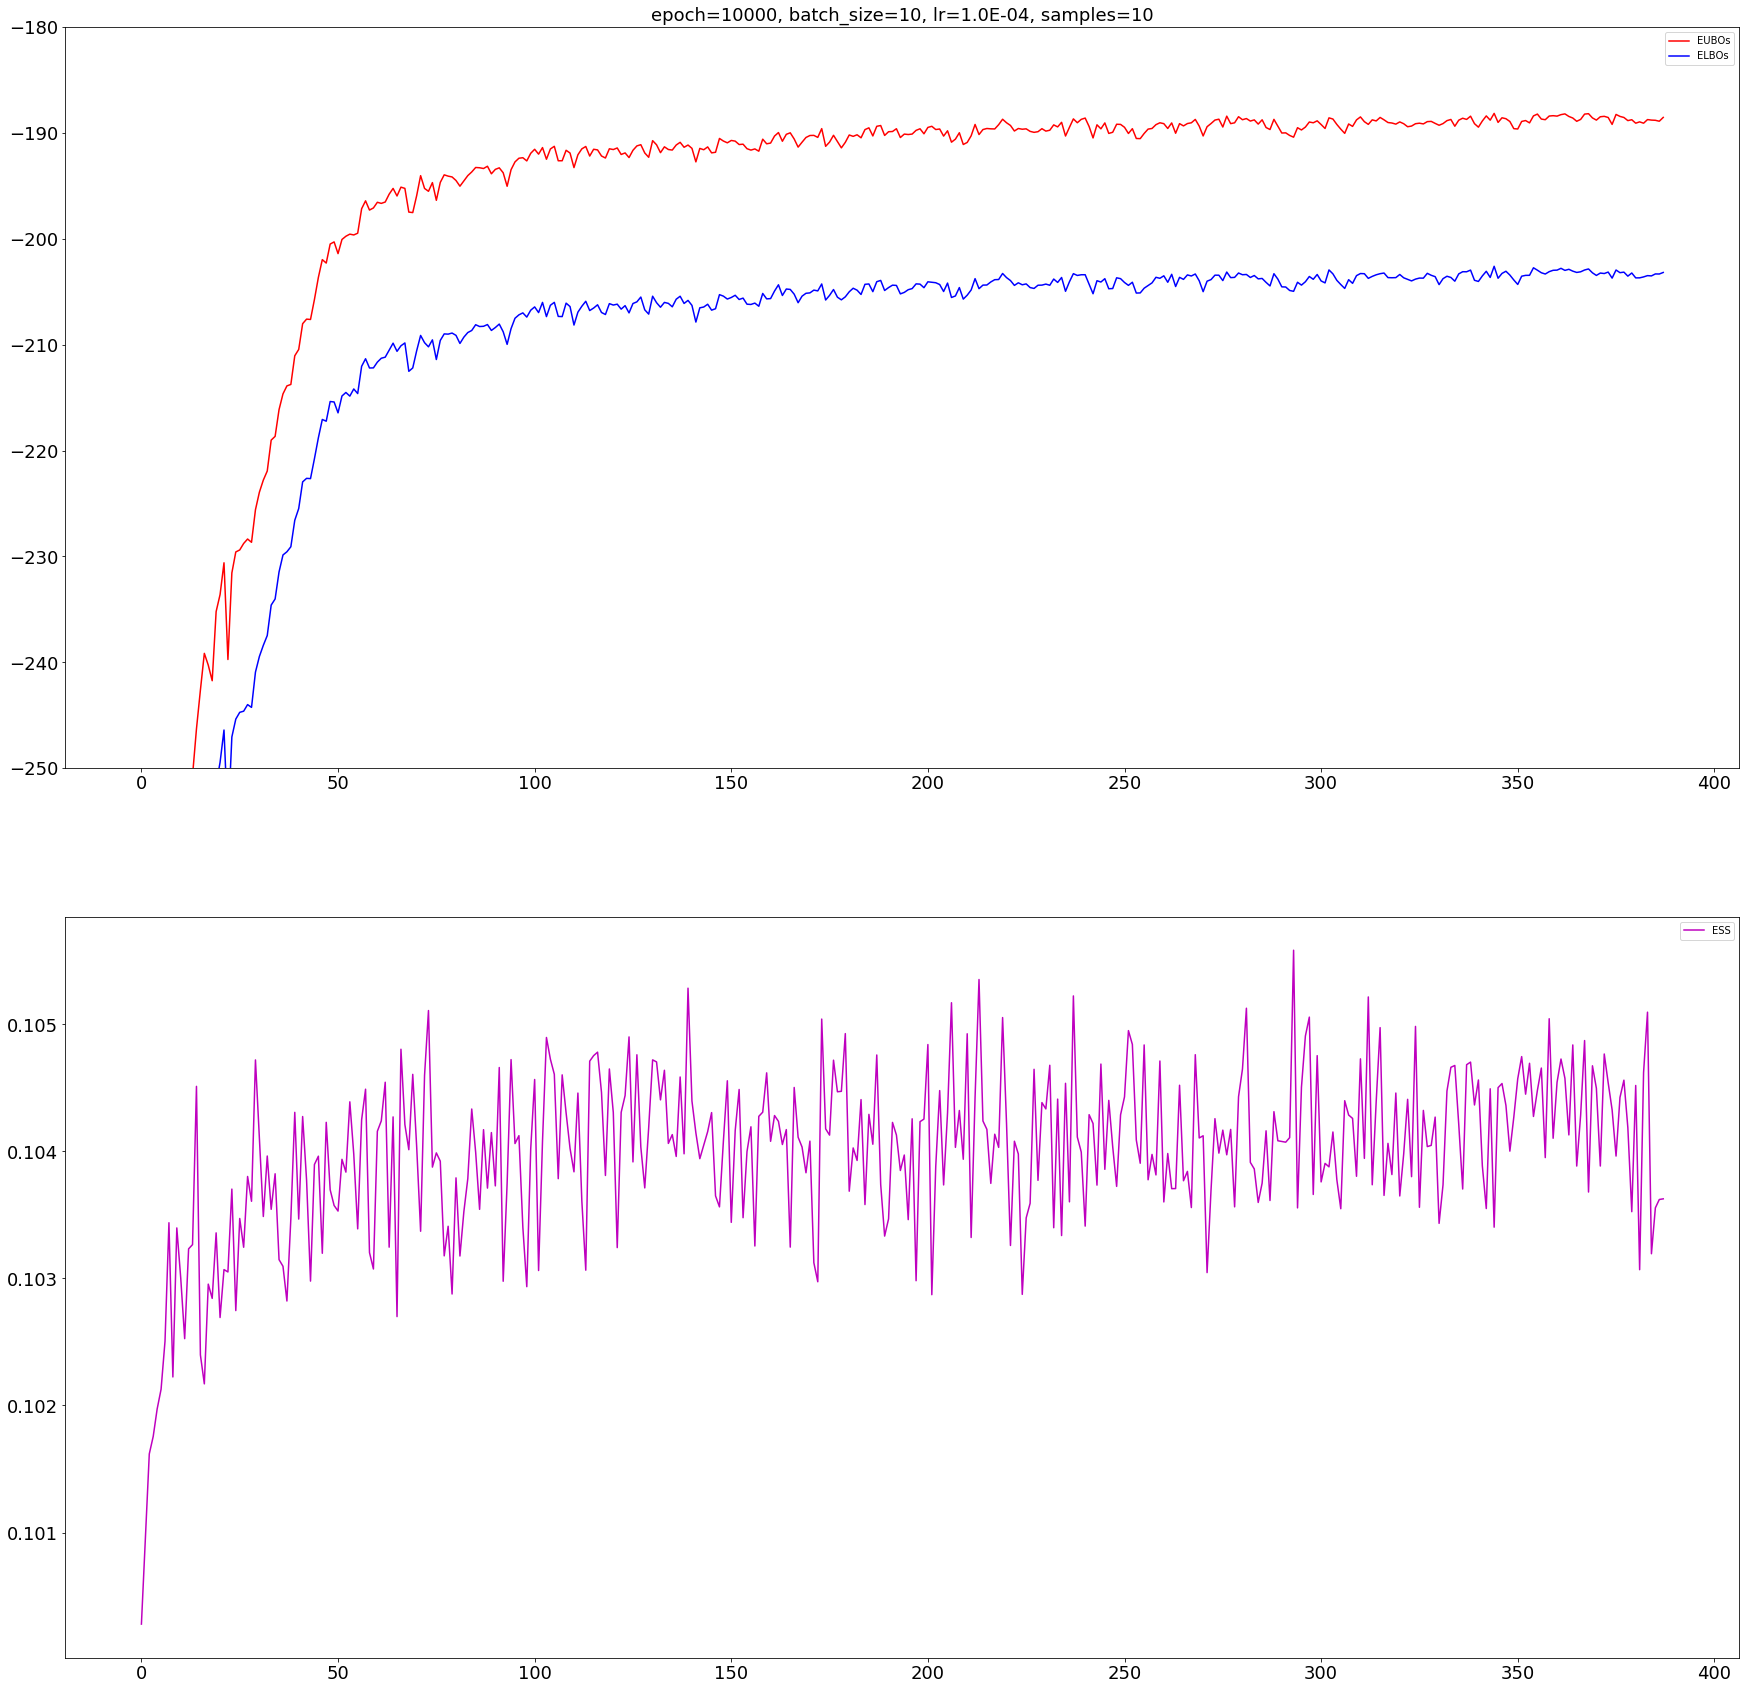

In [15]:
plot_results(EUBOs, ELBOs, ESSs, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [16]:
BATCH_SIZE = 50
prior_mean = torch.zeros((BATCH_SIZE, K, D))
prior_sigma = torch.ones((BATCH_SIZE, K, D))
prior_alpha = torch.ones((BATCH_SIZE, K, D)) * 2.0
prior_beta = torch.ones((BATCH_SIZE, K, D)) * 2.0

indices = torch.randperm(num_seqs)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
batch_Xs = Xs[batch_indices]
batch_Xs = shuffler(batch_Xs, N, K, D, BATCH_SIZE)

def test(Xs, Pi, N, K, D, steps, batch_size):
    for m in range(steps):
        if m == 0:
            mus, precisions, log_p = inti_global(K, D, prior_mean, prior_sigma, prior_alpha, prior_beta, batch_size)
            Z, log_q_z = E_step(Xs, mus, precisions, N, D, K)
        else:
            data = torch.cat((Xs, Z), dim=-1).view(batch_size*N, -1)
            alpha, beta, precisions, mus_mean, mus_sigma, mus = enc(data, K, D, 1, batch_size)            
            Z, log_q_z = E_step(Xs, mus[0], precisions[0], N, D, K)
    return Z, mus[0], precisions[0]


def plot_final_samples(Xs, Zs, mus, precisions, steps, batch_size):
    colors = ['r', 'b', 'orange']
    fig = plt.figure(figsize=(25,50))
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = Xs[b].data.numpy()
        z = Zs[b].data.numpy()
        mu = mus[b].data.numpy()
        precision = precisions[b].data.numpy()

        covs = np.zeros((K, D, D))
        assignments = np.nonzero(z)[1]
        for k in range(K):
            covs[k] = np.diag(1. / precision[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=covs[k], pos=mu[k], nstd=2, ax=ax, alpha=0.2)
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
    plt.savefig('amorgibbs_samples_steps=%d.svg' % (steps))

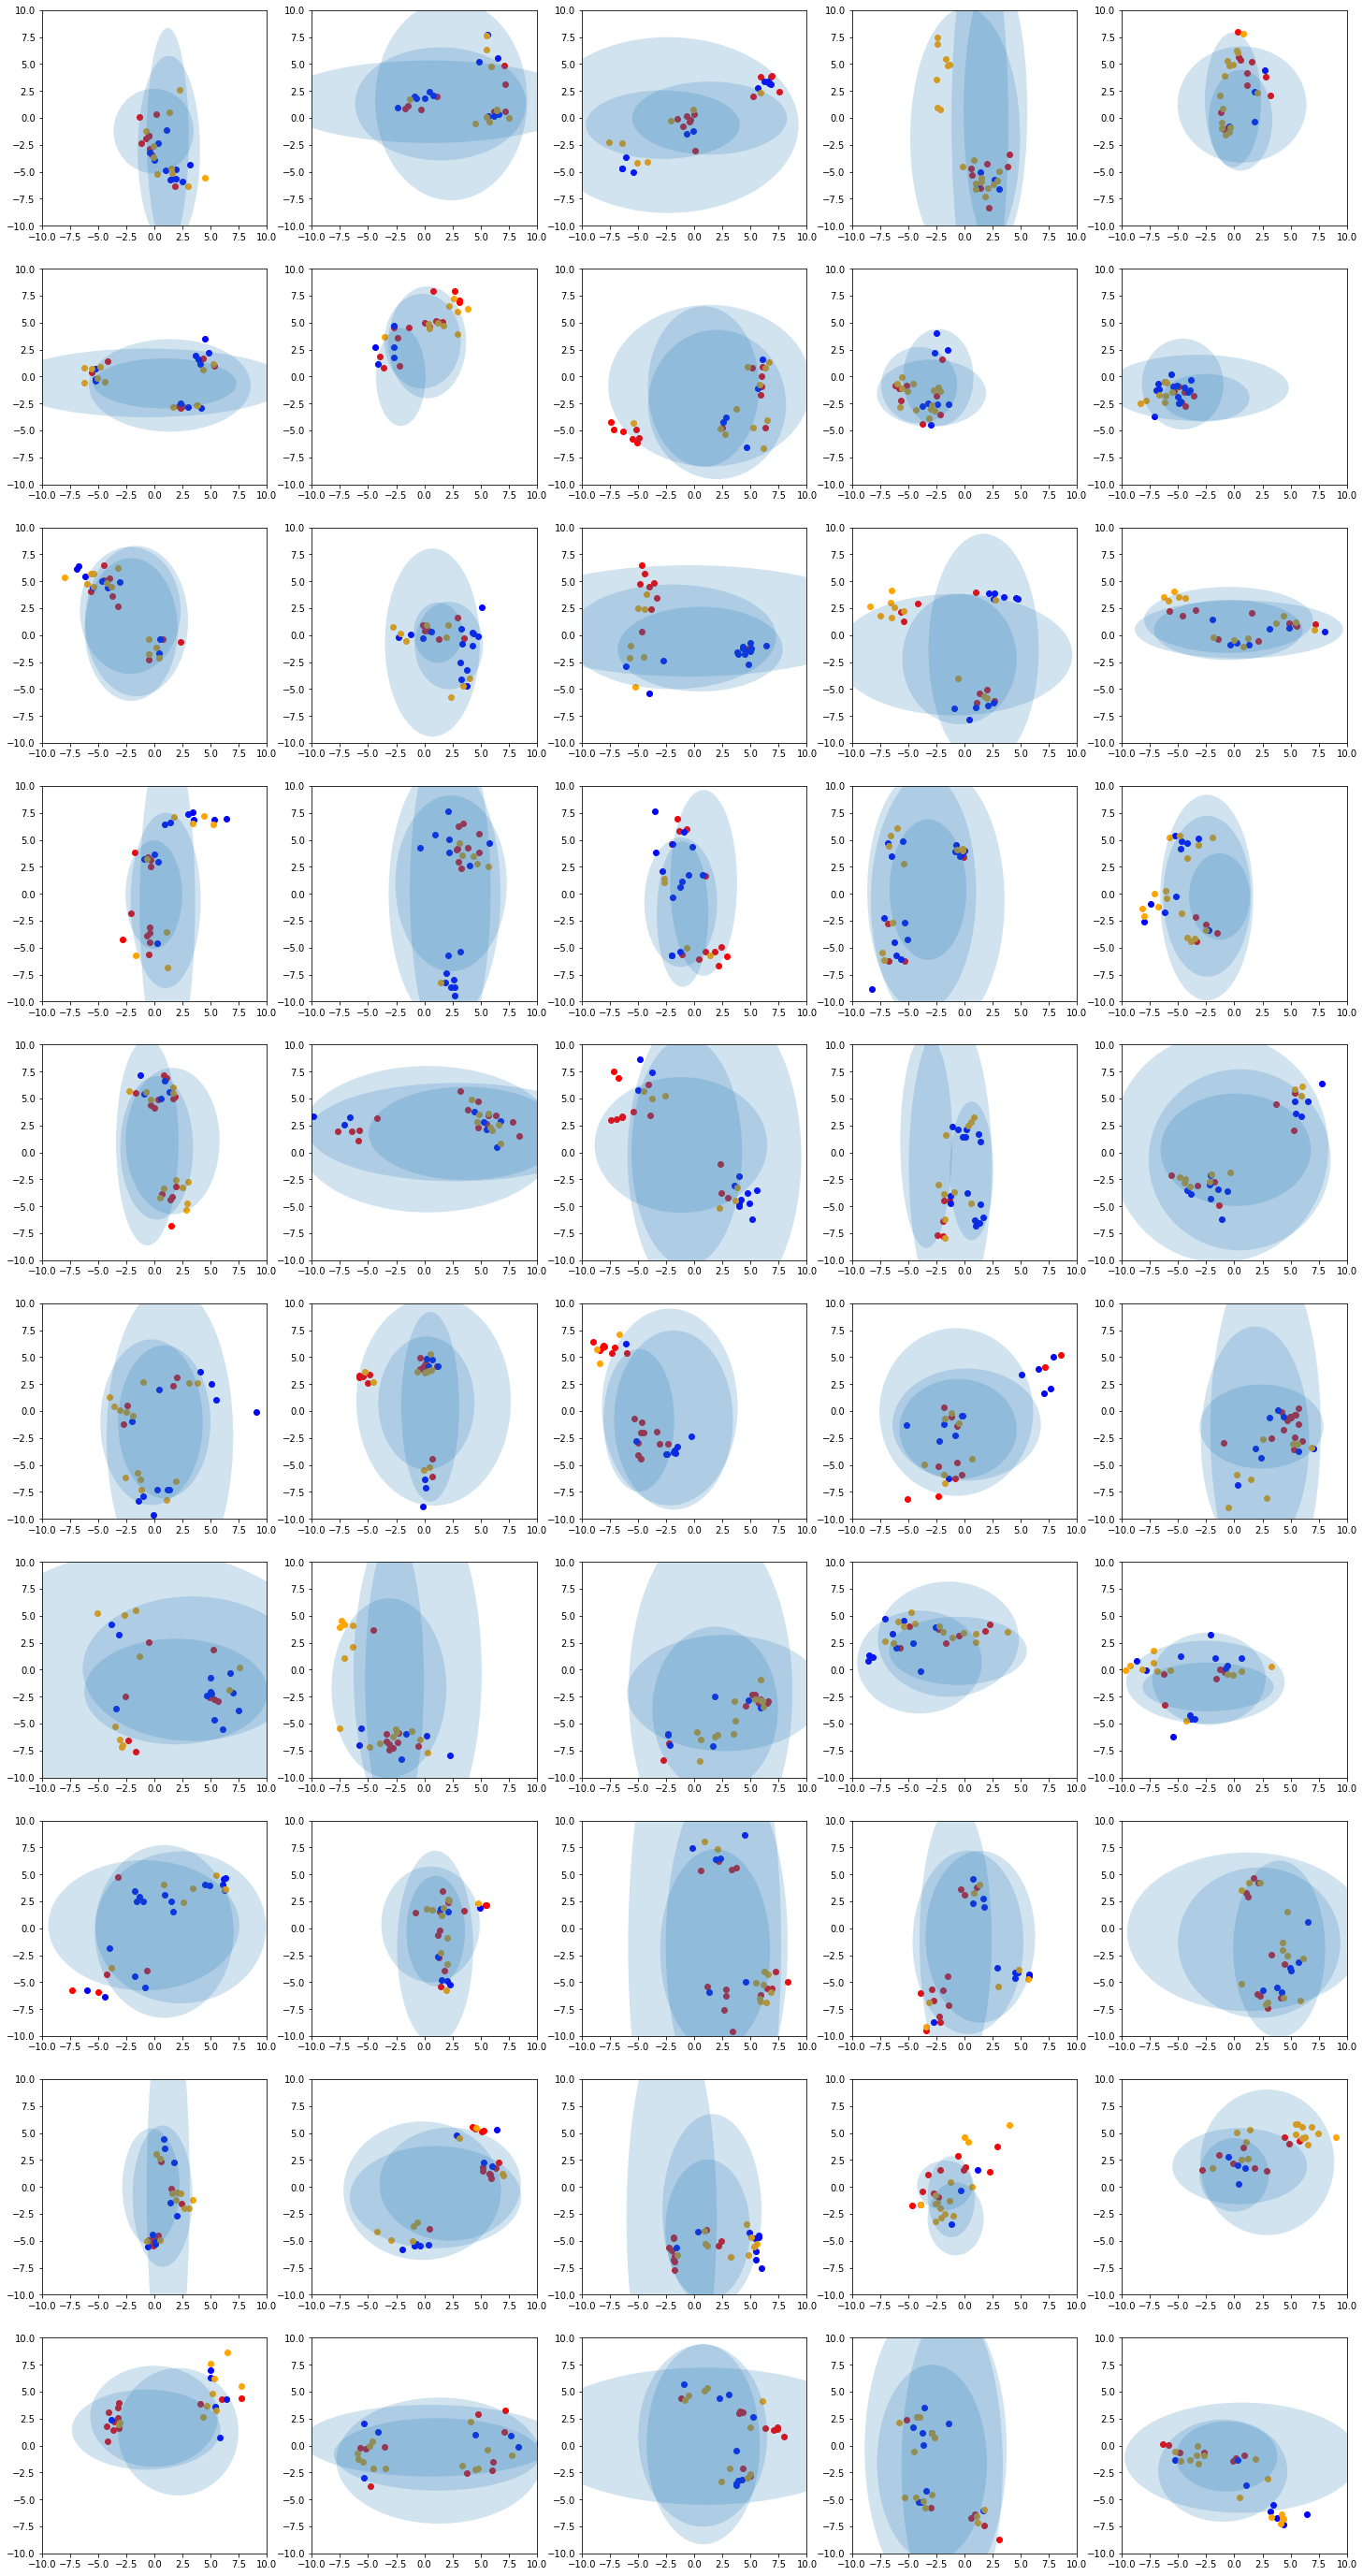

In [18]:
STEPS = 100
Zs_samples, mus_samples, precisions_samples = test(batch_Xs, Pi, N, K, D, STEPS, BATCH_SIZE)
plot_final_samples(batch_Xs, Zs_samples, mus_samples, precisions_samples, STEPS, BATCH_SIZE)